# Section A: Convolutinal Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
Implement an image classifier using a deep learning network, to classify images into 11 classes of vegetables.<br/>
We will build two models for two different input sizes (23x23 and 101x101)<br/>
We want to compare the two classification models and their results

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import cv2
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Set the random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

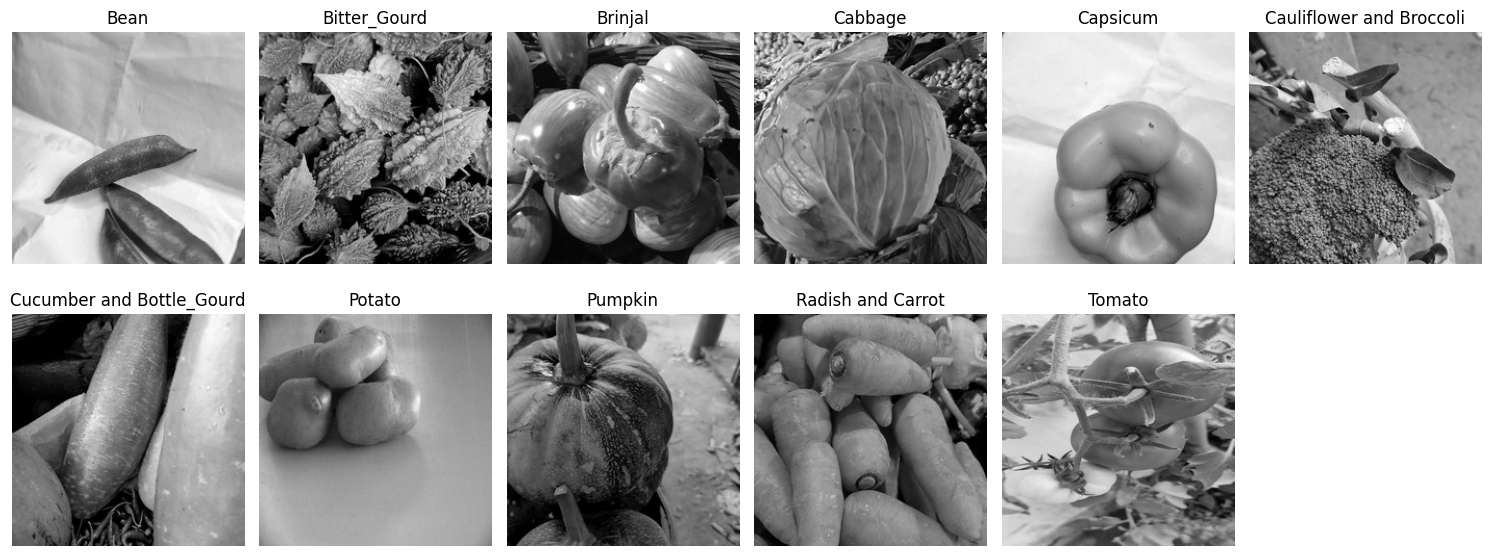

In [2]:
def show_images(folder_path):
    class_names = sorted(os.listdir(folder_path))
    plt.figure(figsize=(15, 6))
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(folder_path, cls)
        img_name = os.listdir(class_dir)[random.randint(0,9)]
        img = cv2.imread(os.path.join(class_dir, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images('Datasets/train')

# | Preprocess Data

From observation, there are many mistakes within the dataset (images in wrong class, incorrect class labels)
I had to remove images/rename file names.

In [2]:
import os

# Paths to dataset folders
base_path = 'Datasets'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

image_size_small = (23, 23)
image_size_large = (101, 101)

def convert_to_grayscale(image, label):
    if tf.shape(image)[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)
    return image, label

train_data_23 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
val_data_23 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')
test_data_23 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_small, color_mode='grayscale')

train_data_101 = image_dataset_from_directory(train_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
val_data_101 = image_dataset_from_directory(val_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')
test_data_101 = image_dataset_from_directory(test_path, labels='inferred', image_size=image_size_large, color_mode='grayscale')

Found 7695 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7695 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [3]:
def seperate_dataset_object(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image)
        y.append(label)
    X = tf.concat(X, axis=0).numpy()
    y = tf.concat(y, axis=0).numpy()
    return X, y

X_train_23, y_train_23 = seperate_dataset_object(train_data_23)
X_val_23, y_val_23 = seperate_dataset_object(val_data_23)
X_test_23, y_test_23 = seperate_dataset_object(test_data_23)

X_train_101, y_train_101 = seperate_dataset_object(train_data_101)
X_val_101, y_val_101 = seperate_dataset_object(val_data_101)
X_test_101, y_test_101 = seperate_dataset_object(test_data_101)

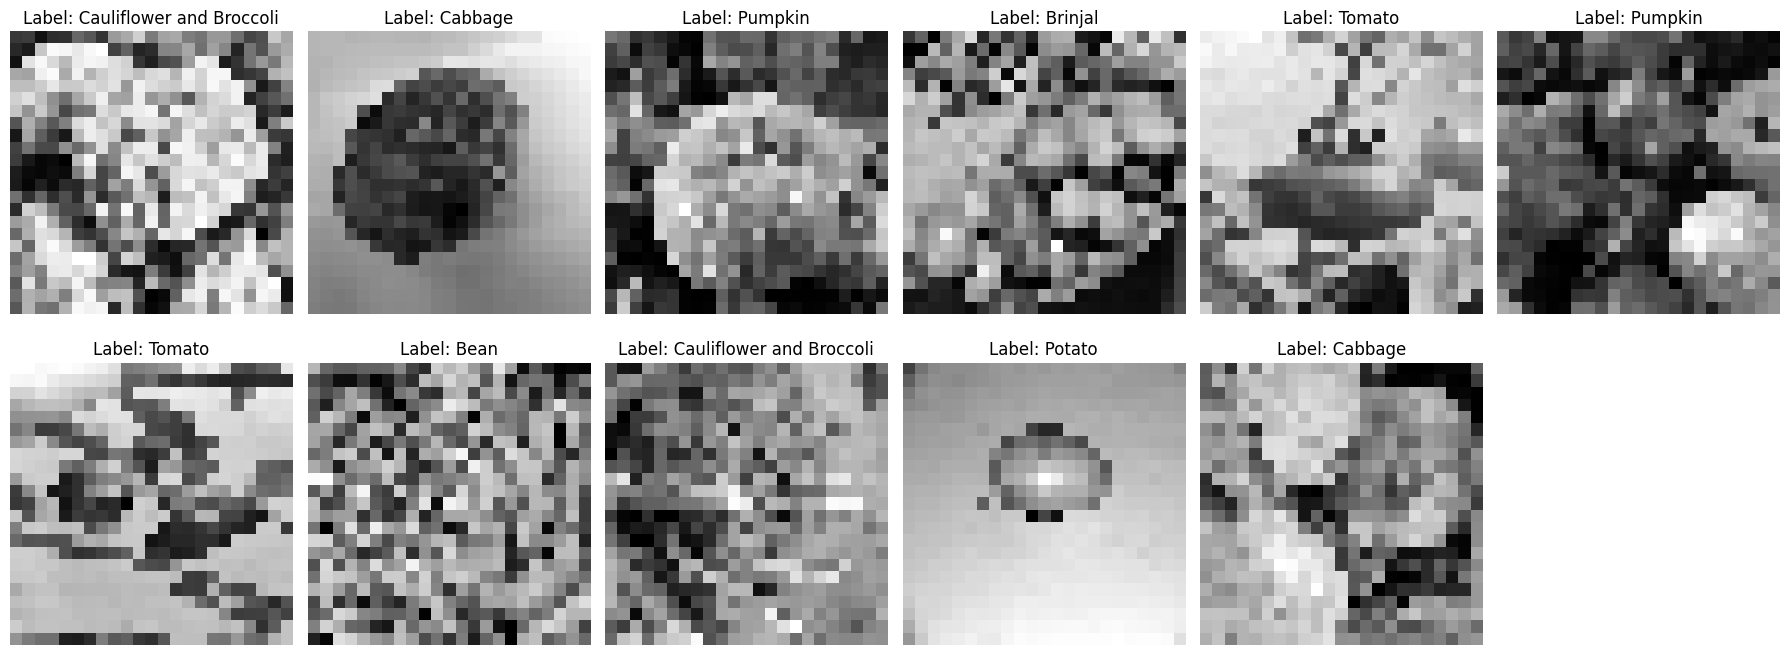

In [4]:
def show_sample_images(X, y, class_names):
    plt.figure(figsize=(18, 7))
    indices = random.sample(range(len(X)), len(class_names))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, len(class_names)//2 + 1, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.title(f"Label: {class_names[y[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = sorted(os.listdir(train_path))
show_sample_images(X_train_23, y_train_23, class_names)

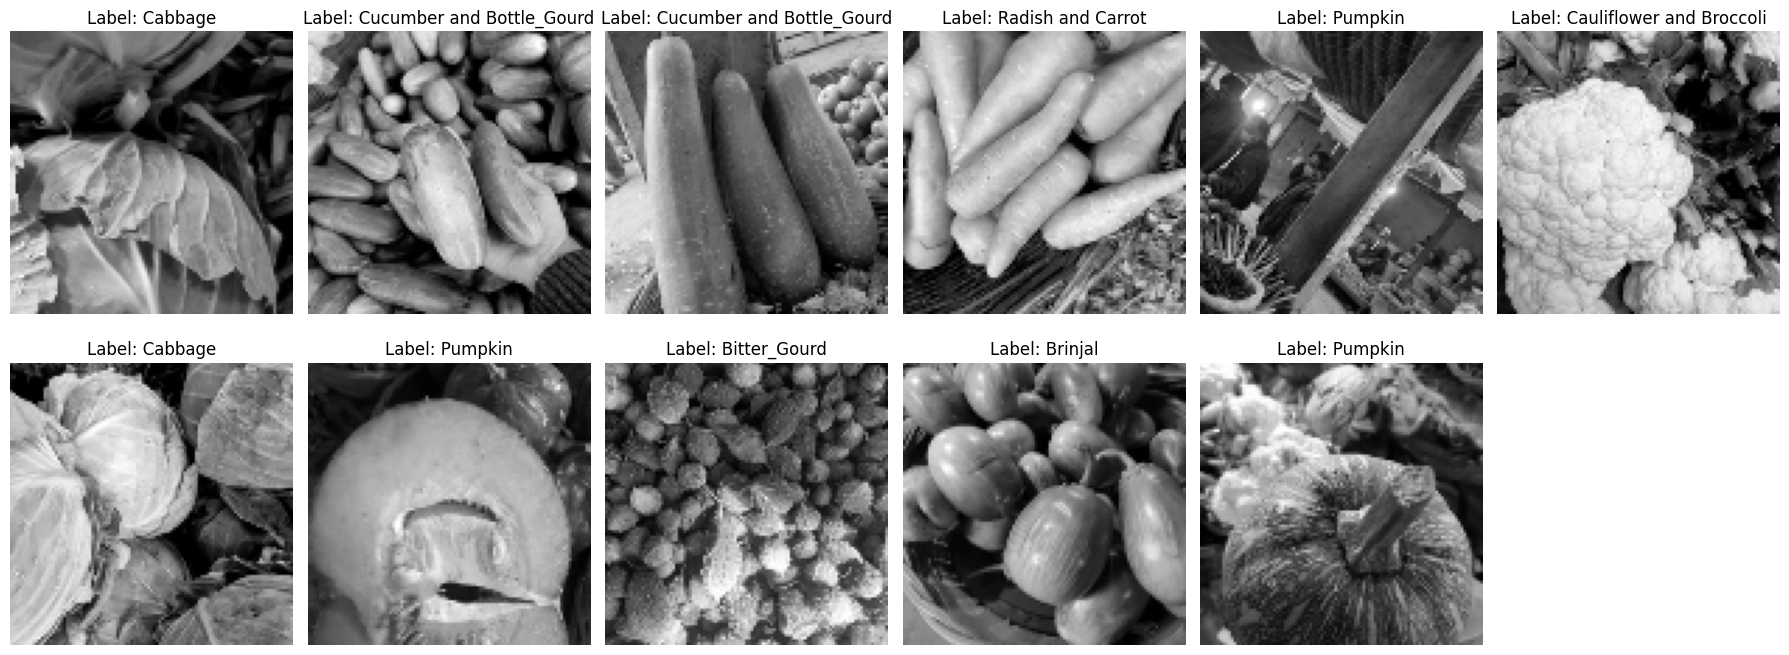

In [5]:
show_sample_images(X_train_101, y_train_101, class_names)

## Class Distribution and Balance

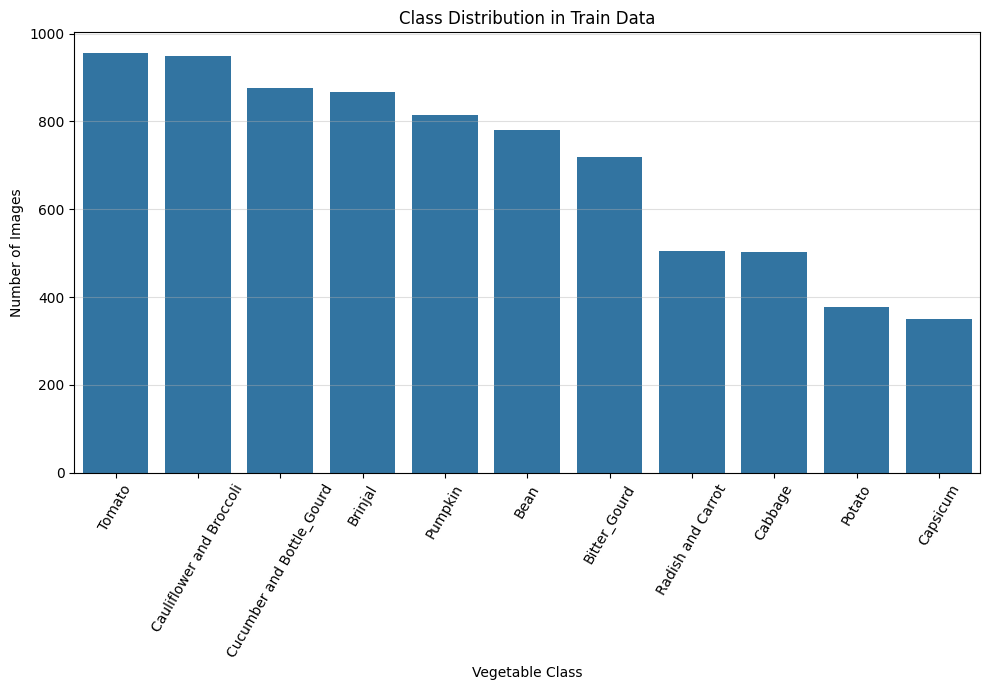

In [6]:
label_names = [class_names[idx] for idx in y_train_23]
num_classes = len(class_names)

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Data")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

There is imbalance of data in the train dataset, there are two solutions:
- Add class weights so the model knows which class has more impact
- Add data through data augmentation to balance the dataset

### Class Weights

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_23)),y=np.array(y_train_23))
# Convert to Series
class_weight_dict = pd.Series(class_weights, index=class_names)
print(f"Class weights: \n\n{class_weight_dict}")
class_weight_dict = dict(enumerate(class_weights))

Class weights: 

Bean                         0.896853
Bitter_Gourd                 0.971591
Brinjal                      0.805928
Cabbage                      1.390746
Capsicum                     1.993007
Cauliflower and Broccoli     0.737917
Cucumber and Bottle_Gourd    0.799481
Potato                       1.855558
Pumpkin                      0.859392
Radish and Carrot            1.387987
Tomato                       0.732508
dtype: float64


### Data Augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Find how many images per class
unique, counts = np.unique(y_train_23, return_counts=True)
class_counts = dict(zip(unique, counts))

target_count = 3000  # The target no. of images per class after augmentation, 3000

aug_X_train_23 = []
aug_y_train_23 = []

# Loop through each class
for class_idx in unique:
    class_mask = y_train_23 == class_idx  # Mask for current class
    X_class = X_train_23[class_mask]      # Images of current class
    y_class = y_train_23[class_mask]      # Labels of current class
    n_to_add = target_count - len(X_class)  # Number of images to add for balancing
    if n_to_add > 0:
        # Use ImageDataGenerator to augment images for the current class
        aug_iter = datagen.flow(X_class, y_class, batch_size=32, shuffle=True)
        X_aug, y_aug = [], []
        while len(X_aug) < n_to_add:
            X_batch, y_batch = next(aug_iter)
            X_aug.append(X_batch)
            y_aug.append(y_batch)
        # Concatenate and trim to required number of images
        X_aug = np.concatenate(X_aug, axis=0)[:n_to_add]
        y_aug = np.concatenate(y_aug, axis=0)[:n_to_add]
        # Combine original and augmented images/labels
        aug_X_train_23.append(np.concatenate([X_class, X_aug], axis=0))
        aug_y_train_23.append(np.concatenate([y_class, y_aug], axis=0))
    else:
        # If already enough images, just add the originals
        aug_X_train_23.append(X_class)
        aug_y_train_23.append(y_class)

# Concatenate all classes to form the final balanced training set
aug_X_train_23 = np.concatenate(aug_X_train_23, axis=0)
aug_y_train_23 = np.concatenate(aug_y_train_23, axis=0)

print("Original shape: ", X_train_23.shape, y_train_23.shape)
print("Balanced shape: ", aug_X_train_23.shape, aug_y_train_23.shape)

# One-hot encode the augmented labels
aug_y_train_23_cat = to_categorical(aug_y_train_23, num_classes)

Original shape:  (7695, 23, 23, 1) (7695,)
Balanced shape:  (33000, 23, 23, 1) (33000,)


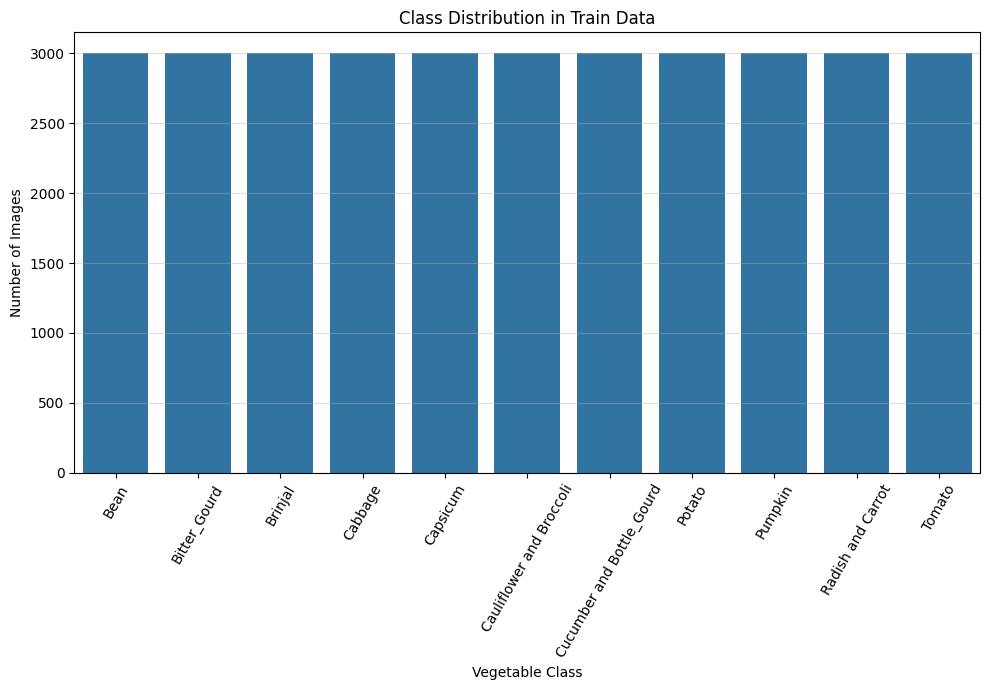

In [9]:
label_names = [class_names[idx] for idx in aug_y_train_23]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Data")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

## Normalization
We apply normalization to the features as:
- The model expects values from 0 to 255
- Models train faster and more stably when inputs are on a consistent scale. (faster convergence)
- Prevents certain features (e.g., brighter pixels) from dominating.

In [10]:
# I will normalize input data by adding a Rescalling() layer into our models
from keras.layers import Rescaling
# Rescaling(1.0/255, input_shape=(23, 23, 1))

# | 23x23 Model

In [11]:
# One-hot encode the labels
y_train_23_cat = to_categorical(y_train_23, num_classes)
y_val_23_cat = to_categorical(y_val_23, num_classes)
y_test_23_cat = to_categorical(y_test_23, num_classes)

In [12]:
# Evaluate the model on the test set
def evaluate_model(model, X, y_true, class_names):
    y_pred_probs = model.predict(X)
    accuracy = np.mean(np.argmax(y_pred_probs, axis=1) == y_true)
    print(f"Overall prediction accuracy: {accuracy:.4f}")
    y_pred = np.argmax(y_pred_probs, axis=1)
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model.name})')
    plt.xticks()
    plt.yticks()
    plt.tight_layout()
    plt.show()

In [13]:
# Define a function for plotting learning curves
def plot_learning_curve(history):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    
    # Training loss and validation loss
    ax1=ax[0]
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Number of Epochs")
    ax1.set_title("Training and Validation Loss")

    # Training accuracy and validation accuracy
    ax2=ax[1]
    ax2.plot(history.history["accuracy"], label="Training Accuracy")
    ax2.plot(history.history["val_accuracy"], label="Validation Accuracy")
    ax2.legend()
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Number of Epochs")
    ax2.set_title("Training and Validation Accuracy")
    plt.show()

## Model training

In [ ]:
# Define the model
baseline_23 = Sequential(name="baseline_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)), # Normalize data
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
baseline_23.compile(
    optimizer=Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Model summary
baseline_23.summary()

Model: "baseline_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 23, 23, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 128)         

In [ ]:
baseline_23_history = baseline_23.fit(
    X_train_23, y_train_23_cat, 
    batch_size=32,
    epochs=100,
    validation_data=(X_val_23, y_val_23_cat),
)

Epoch 1/100
241/241 [==============================] - 6s 9ms/step - loss: 2.2744 - accuracy: 0.1804 - val_loss: 2.2011 - val_accuracy: 0.2082
Epoch 2/100
241/241 [==============================] - 2s 7ms/step - loss: 2.0400 - accuracy: 0.2980 - val_loss: 1.9012 - val_accuracy: 0.3632
Epoch 3/100
241/241 [==============================] - 2s 8ms/step - loss: 1.8558 - accuracy: 0.3622 - val_loss: 1.7743 - val_accuracy: 0.3932
Epoch 4/100
241/241 [==============================] - 2s 8ms/step - loss: 1.6801 - accuracy: 0.4366 - val_loss: 1.5799 - val_accuracy: 0.4659
Epoch 5/100
241/241 [==============================] - 2s 8ms/step - loss: 1.5514 - accuracy: 0.4801 - val_loss: 1.4681 - val_accuracy: 0.5027
Epoch 6/100
241/241 [==============================] - 2s 8ms/step - loss: 1.3975 - accuracy: 0.5372 - val_loss: 1.3749 - val_accuracy: 0.5345
Epoch 7/100
241/241 [==============================] - 2s 9ms/step - loss: 1.3088 - accuracy: 0.5617 - val_loss: 1.2779 - val_accuracy: 0.5650

69/69 [==============================] - 0s 2ms/step
Overall prediction accuracy: 0.7795
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.73      0.81      0.77       200
             Bitter_Gourd       0.78      0.86      0.82       200
                  Brinjal       0.84      0.80      0.82       200
                  Cabbage       0.81      0.65      0.72       200
                 Capsicum       0.87      0.79      0.82       200
 Cauliflower and Broccoli       0.66      0.76      0.71       200
Cucumber and Bottle_Gourd       0.76      0.82      0.79       200
                   Potato       0.83      0.73      0.78       200
                  Pumpkin       0.88      0.81      0.84       200
        Radish and Carrot       0.77      0.76      0.76       200
                   Tomato       0.72      0.79      0.75       200

                 accuracy                           0.78      2200
              

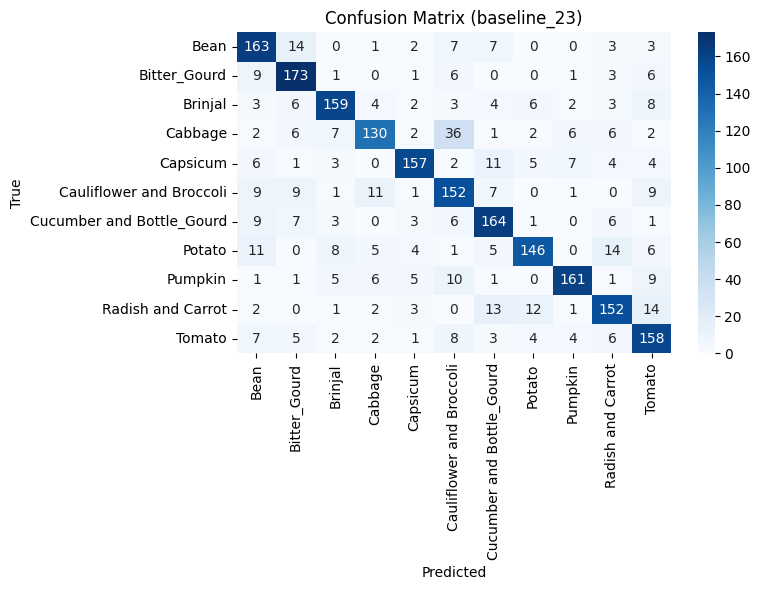

In [98]:
evaluate_model(baseline_23, X_test_23, y_test_23, class_names)

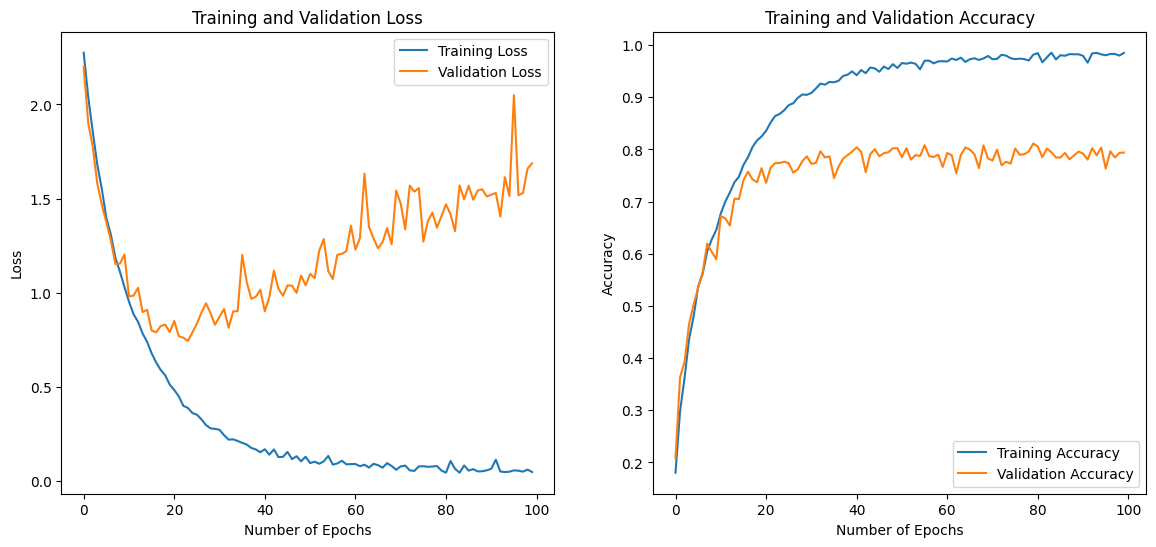

In [ ]:
plot_learning_curve(baseline_23_history)

val loss increases after 20 epochs while train loss improves, val and test accuary is low.
- The model shows signs of overfitting

In [25]:
# callbacks = [
#     EarlyStopping(
#         monitor = "val_loss",
#         min_delta=1e-2,
#         patience=10,
#         verbose=1
#     )
# ]

I tried to implemet EarlyStopping, however the model would get stuck and not improve. Could be due to the way Early Stopping makes the model focus too much on one metric.

## Model Improvement

### Class Weights

In [100]:
# Define the model
classWeights_23 = Sequential(name="classWeights_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)), # Normalize data
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
classWeights_23.compile(
    optimizer=Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Model summary
classWeights_23.summary()

Model: "classWeights_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 23, 23, 1)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 2, 2, 128)     

In [101]:
classWeights_23_history = classWeights_23.fit(
    X_train_23, y_train_23_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_23, y_val_23_cat),
    class_weight=class_weight_dict # Use class weights
)

Epoch 1/100
241/241 [==============================] - 2s 6ms/step - loss: 2.3316 - accuracy: 0.1354 - val_loss: 2.2246 - val_accuracy: 0.2045
Epoch 2/100
241/241 [==============================] - 1s 5ms/step - loss: 2.2135 - accuracy: 0.1970 - val_loss: 2.1012 - val_accuracy: 0.2836
Epoch 3/100
241/241 [==============================] - 1s 5ms/step - loss: 2.0701 - accuracy: 0.2642 - val_loss: 1.9981 - val_accuracy: 0.3286
Epoch 4/100
241/241 [==============================] - 1s 5ms/step - loss: 1.9314 - accuracy: 0.3301 - val_loss: 1.7610 - val_accuracy: 0.3941
Epoch 5/100
241/241 [==============================] - 1s 5ms/step - loss: 1.7725 - accuracy: 0.3830 - val_loss: 1.6300 - val_accuracy: 0.4814
Epoch 6/100
241/241 [==============================] - 1s 5ms/step - loss: 1.6558 - accuracy: 0.4329 - val_loss: 1.4792 - val_accuracy: 0.5023
Epoch 7/100
241/241 [==============================] - 1s 5ms/step - loss: 1.5552 - accuracy: 0.4615 - val_loss: 1.3859 - val_accuracy: 0.5309

69/69 [==============================] - 0s 1ms/step
Overall prediction accuracy: 0.7795
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.79      0.80      0.79       200
             Bitter_Gourd       0.85      0.81      0.83       200
                  Brinjal       0.71      0.91      0.80       200
                  Cabbage       0.81      0.65      0.72       200
                 Capsicum       0.92      0.82      0.87       200
 Cauliflower and Broccoli       0.60      0.77      0.68       200
Cucumber and Bottle_Gourd       0.72      0.85      0.78       200
                   Potato       0.93      0.70      0.80       200
                  Pumpkin       0.82      0.84      0.83       200
        Radish and Carrot       0.88      0.69      0.77       200
                   Tomato       0.71      0.73      0.72       200

                 accuracy                           0.78      2200
              

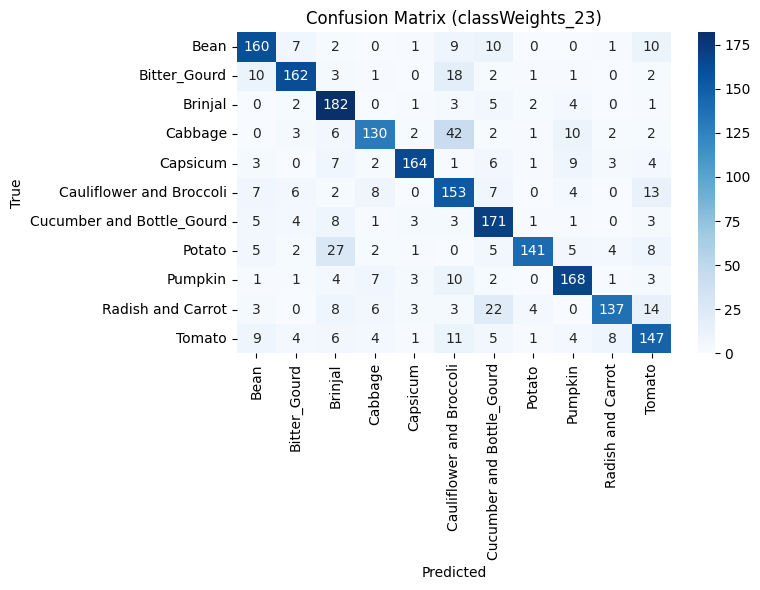

In [102]:
evaluate_model(classWeights_23, X_test_23, y_test_23, class_names)

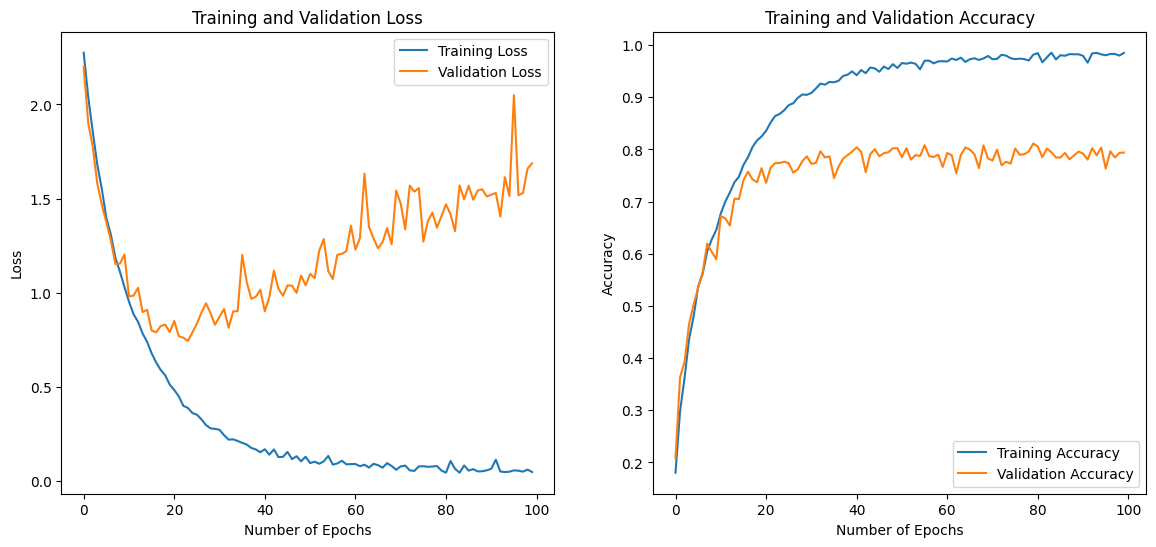

In [ ]:
plot_learning_curve(classWeights_23_history)

### Data Augmentation
We implement Data Augmentation as it:
- Increases dataset diversity
- Helps with limited training data
- Reduce overfitting

In [15]:
# Define the model
aug_23 = Sequential(name="aug_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
aug_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
aug_23.summary()

Model: "aug_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 23, 23, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 21, 21, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856

In [16]:
aug_23_history = aug_23.fit(
    aug_X_train_23, aug_y_train_23_cat, 
    batch_size=32,
    epochs=100,
    validation_data=(X_val_23, y_val_23_cat),
)

Epoch 1/100
860/860 [==============================] - 13s 4ms/step - loss: 2.1413 - accuracy: 0.2339 - val_loss: 1.9828 - val_accuracy: 0.3232
Epoch 2/100
860/860 [==============================] - 4s 4ms/step - loss: 1.8451 - accuracy: 0.3682 - val_loss: 1.6370 - val_accuracy: 0.4409
Epoch 3/100
860/860 [==============================] - 4s 4ms/step - loss: 1.6262 - accuracy: 0.4454 - val_loss: 1.3501 - val_accuracy: 0.5509
Epoch 4/100
860/860 [==============================] - 4s 4ms/step - loss: 1.4535 - accuracy: 0.5087 - val_loss: 1.2410 - val_accuracy: 0.5786
Epoch 5/100
860/860 [==============================] - 4s 4ms/step - loss: 1.2906 - accuracy: 0.5640 - val_loss: 1.2279 - val_accuracy: 0.5741
Epoch 6/100
860/860 [==============================] - 4s 4ms/step - loss: 1.1701 - accuracy: 0.6085 - val_loss: 0.8975 - val_accuracy: 0.7177
Epoch 7/100
860/860 [==============================] - 4s 4ms/step - loss: 1.0631 - accuracy: 0.6455 - val_loss: 0.9554 - val_accuracy: 0.690

69/69 [==============================] - 0s 1ms/step
Overall prediction accuracy: 0.7891
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.82      0.79      0.80       200
             Bitter_Gourd       0.72      0.85      0.78       200
                  Brinjal       0.75      0.85      0.80       200
                  Cabbage       0.83      0.68      0.75       200
                 Capsicum       0.92      0.86      0.89       200
 Cauliflower and Broccoli       0.63      0.72      0.67       200
Cucumber and Bottle_Gourd       0.77      0.81      0.79       200
                   Potato       0.86      0.77      0.81       200
                  Pumpkin       0.78      0.82      0.80       200
        Radish and Carrot       0.88      0.78      0.83       200
                   Tomato       0.79      0.73      0.76       200

                 accuracy                           0.79      2200
              

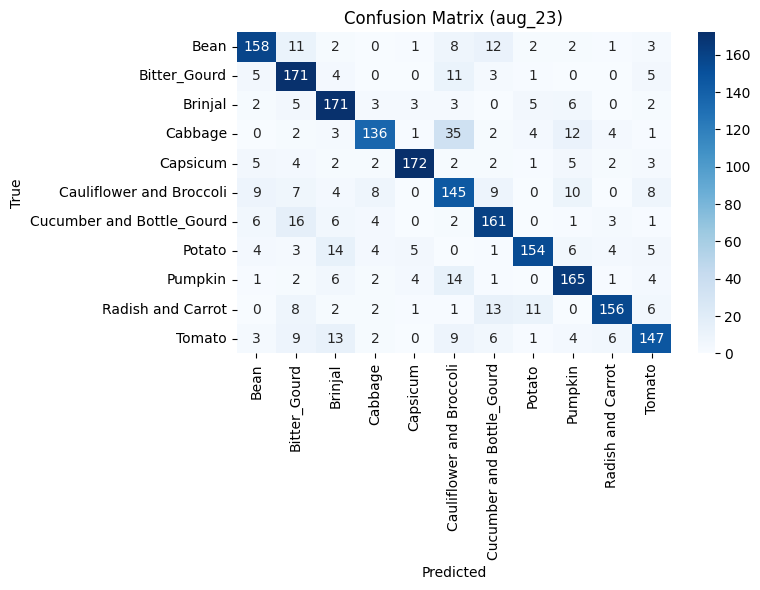

In [17]:
evaluate_model(aug_23, X_test_23, y_test_23, class_names)

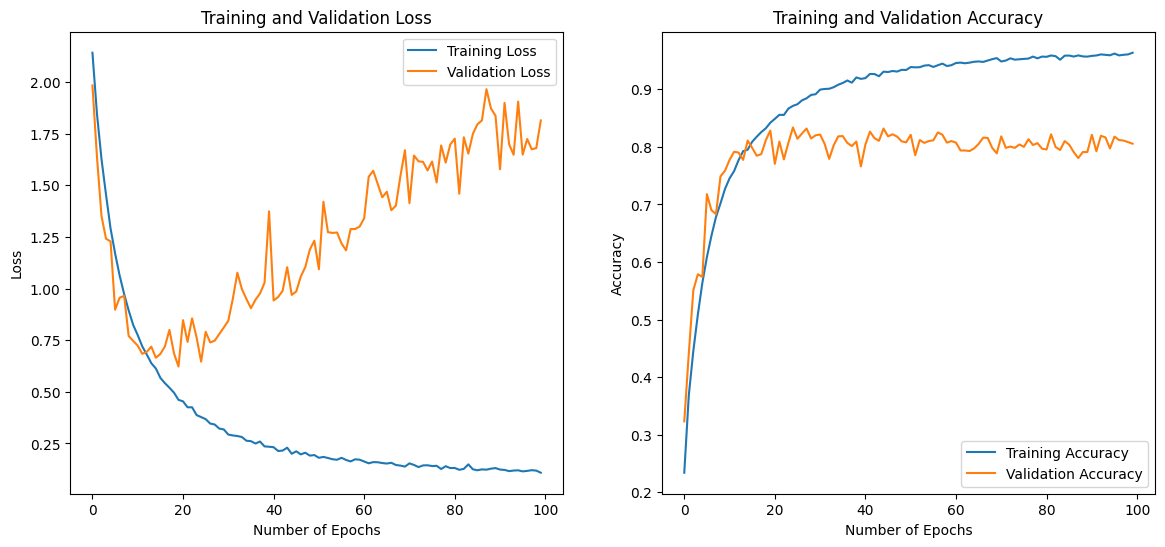

In [18]:
plot_learning_curve(aug_23_history)

Observations:
- Training time increases but the model seems to be overall more accurate

### BatchNormalization

In [104]:
batchNorm_23 = Sequential(name="batchNorm_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)), 
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

batchNorm_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

batchNorm_23.summary()

Model: "batchNorm_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 23, 23, 1)         0         
                                                                 
 conv2d_44 (Conv2D)          (None, 23, 23, 32)        320       
                                                                 
 batch_normalization_23 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_24 (Bat  (None, 11, 11, 64)      

In [105]:
batchNorm_23_history = batchNorm_23.fit(
    X_train_23, y_train_23_cat, 
    batch_size=32,
    epochs=100,
    validation_data=(X_val_23, y_val_23_cat),
)

Epoch 1/100
241/241 [==============================] - 2s 7ms/step - loss: 2.1360 - accuracy: 0.3419 - val_loss: 4.9220 - val_accuracy: 0.0959
Epoch 2/100
241/241 [==============================] - 1s 6ms/step - loss: 1.4533 - accuracy: 0.5212 - val_loss: 4.1810 - val_accuracy: 0.1355
Epoch 3/100
241/241 [==============================] - 1s 6ms/step - loss: 1.1384 - accuracy: 0.6218 - val_loss: 1.9012 - val_accuracy: 0.4395
Epoch 4/100
241/241 [==============================] - 2s 6ms/step - loss: 0.9253 - accuracy: 0.6998 - val_loss: 0.8764 - val_accuracy: 0.7109
Epoch 5/100
241/241 [==============================] - 1s 6ms/step - loss: 0.7700 - accuracy: 0.7488 - val_loss: 1.7010 - val_accuracy: 0.4950
Epoch 6/100
241/241 [==============================] - 1s 6ms/step - loss: 0.6546 - accuracy: 0.7860 - val_loss: 1.1695 - val_accuracy: 0.6386
Epoch 7/100
241/241 [==============================] - 2s 6ms/step - loss: 0.5427 - accuracy: 0.8265 - val_loss: 0.9755 - val_accuracy: 0.6886

69/69 [==============================] - 0s 2ms/step
Overall prediction accuracy: 0.8291
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.88      0.88      0.88       200
             Bitter_Gourd       0.91      0.80      0.85       200
                  Brinjal       0.73      0.90      0.81       200
                  Cabbage       0.98      0.64      0.77       200
                 Capsicum       0.93      0.82      0.88       200
 Cauliflower and Broccoli       0.77      0.71      0.74       200
Cucumber and Bottle_Gourd       0.82      0.92      0.87       200
                   Potato       0.83      0.86      0.84       200
                  Pumpkin       0.90      0.86      0.88       200
        Radish and Carrot       0.83      0.87      0.85       200
                   Tomato       0.68      0.85      0.76       200

                 accuracy                           0.83      2200
              

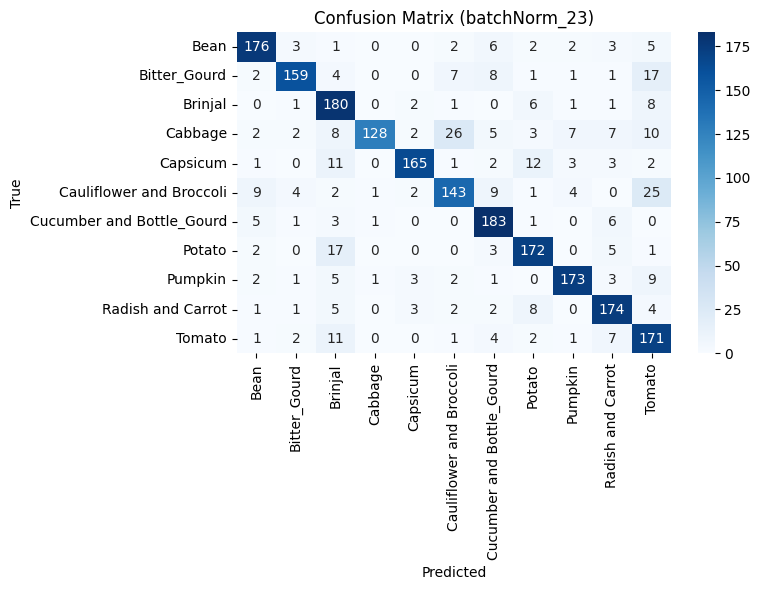

In [106]:
evaluate_model(batchNorm_23, X_test_23, y_test_23, class_names)

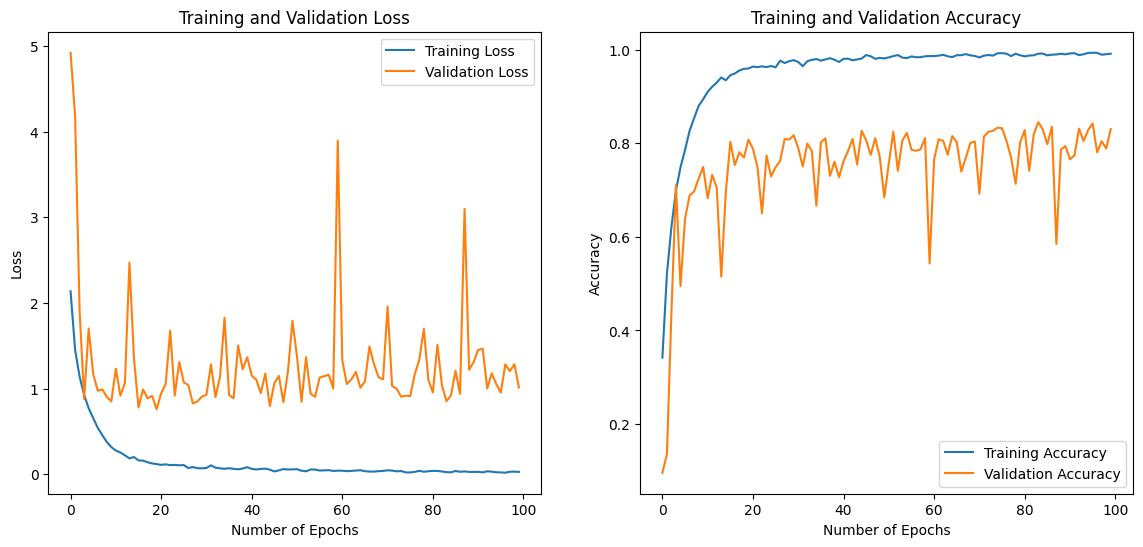

In [107]:
plot_learning_curve(batchNorm_23_history)

### More Layers

In [110]:
# Define the model
model1_23 = Sequential(name="model1_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model1_23.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1_23.summary()

Model: "model1_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 23, 23, 1)         0         
                                                                 
 conv2d_51 (Conv2D)          (None, 23, 23, 32)        320       
                                                                 
 batch_normalization_31 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_52 (Conv2D)          (None, 23, 23, 32)        9248      
                                                                 
 batch_normalization_32 (Bat  (None, 23, 23, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 11, 11, 32)       0 

In [111]:
model1_23_history = model1_23.fit(
    aug_X_train_23, aug_y_train_23_cat, 
    batch_size=32,
    epochs=100,
    validation_data=(X_val_23, y_val_23_cat),
)

Epoch 1/100
1375/1375 [==============================] - 8s 5ms/step - loss: 1.4920 - accuracy: 0.4973 - val_loss: 1.1466 - val_accuracy: 0.6355
Epoch 2/100
1375/1375 [==============================] - 7s 5ms/step - loss: 0.7821 - accuracy: 0.7455 - val_loss: 0.6005 - val_accuracy: 0.8032
Epoch 3/100
1375/1375 [==============================] - 7s 5ms/step - loss: 0.5126 - accuracy: 0.8367 - val_loss: 0.5577 - val_accuracy: 0.8282
Epoch 4/100
1375/1375 [==============================] - 7s 5ms/step - loss: 0.3725 - accuracy: 0.8805 - val_loss: 0.8523 - val_accuracy: 0.7568
Epoch 5/100
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2810 - accuracy: 0.9105 - val_loss: 0.4629 - val_accuracy: 0.8705
Epoch 6/100
1375/1375 [==============================] - 7s 5ms/step - loss: 0.2272 - accuracy: 0.9275 - val_loss: 1.0167 - val_accuracy: 0.7450
Epoch 7/100
1375/1375 [==============================] - 7s 5ms/step - loss: 0.1898 - accuracy: 0.9401 - val_loss: 0.5134 - val_ac

69/69 [==============================] - 0s 2ms/step
Overall prediction accuracy: 0.9200
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.79      0.96      0.87       200
             Bitter_Gourd       0.96      0.93      0.95       200
                  Brinjal       0.89      0.95      0.92       200
                  Cabbage       0.97      0.86      0.92       200
                 Capsicum       0.95      0.98      0.96       200
 Cauliflower and Broccoli       0.91      0.82      0.86       200
Cucumber and Bottle_Gourd       0.91      0.96      0.94       200
                   Potato       0.95      0.91      0.93       200
                  Pumpkin       0.91      0.91      0.91       200
        Radish and Carrot       0.98      0.90      0.94       200
                   Tomato       0.95      0.93      0.94       200

                 accuracy                           0.92      2200
              

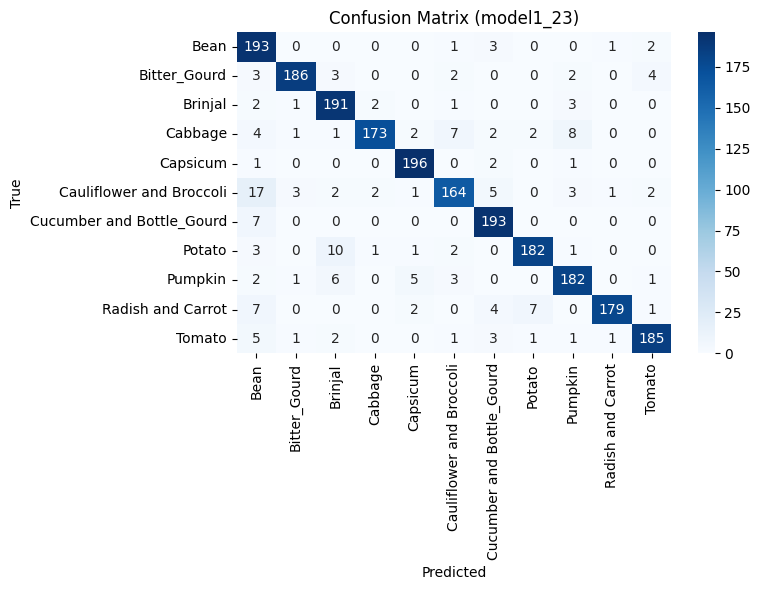

In [112]:
evaluate_model(model1_23, X_test_23, y_test_23, class_names)

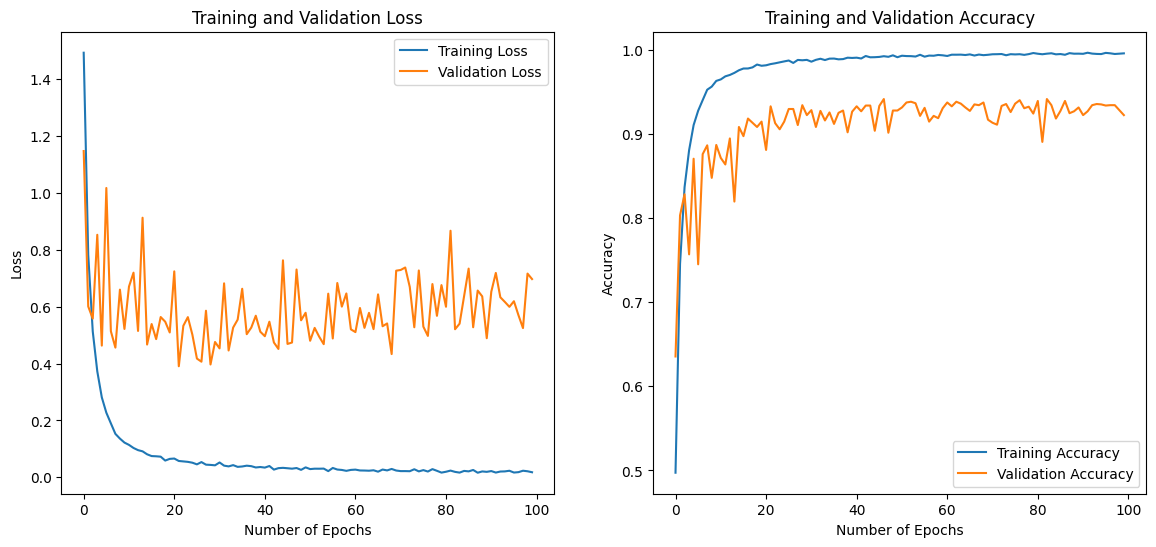

In [113]:
plot_learning_curve(model1_23_history)

### Reduce Overfitting
I added dropout layers to the Conv layers and kernel_regularizer l2 to the dense layer, in addition to removing some layers

In [21]:
model2_23 = Sequential(name="model2_23", layers = [
    Rescaling(1.0/255, input_shape=(23, 23, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2), # Dropout added

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2), # Dropout added

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4), # Dropout added

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)), # L2 regularization added
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model2_23.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2_23.summary()

Model: "model2_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 23, 23, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 32)       0 

In [22]:
model2_23_history = model2_23.fit(
    aug_X_train_23, aug_y_train_23_cat, 
    batch_size=32,
    epochs=150,
    validation_data=(X_val_23, y_val_23_cat),
)

Epoch 1/150
860/860 [==============================] - 6s 6ms/step - loss: 2.4854 - accuracy: 0.2490 - val_loss: 2.0540 - val_accuracy: 0.4000
Epoch 2/150
860/860 [==============================] - 5s 6ms/step - loss: 1.9669 - accuracy: 0.4205 - val_loss: 1.3771 - val_accuracy: 0.6145
Epoch 3/150
860/860 [==============================] - 5s 6ms/step - loss: 1.6477 - accuracy: 0.5172 - val_loss: 1.3049 - val_accuracy: 0.6173
Epoch 4/150
860/860 [==============================] - 5s 6ms/step - loss: 1.3919 - accuracy: 0.6045 - val_loss: 1.4419 - val_accuracy: 0.5723
Epoch 5/150
860/860 [==============================] - 5s 6ms/step - loss: 1.2068 - accuracy: 0.6552 - val_loss: 0.8986 - val_accuracy: 0.7500
Epoch 6/150
860/860 [==============================] - 5s 6ms/step - loss: 1.0784 - accuracy: 0.7006 - val_loss: 0.7214 - val_accuracy: 0.8173
Epoch 7/150
860/860 [==============================] - 5s 6ms/step - loss: 0.9664 - accuracy: 0.7354 - val_loss: 0.7326 - val_accuracy: 0.8068

69/69 [==============================] - 0s 2ms/step
Overall prediction accuracy: 0.9445
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.87      0.99      0.93       200
             Bitter_Gourd       0.96      0.94      0.95       200
                  Brinjal       0.95      0.94      0.95       200
                  Cabbage       0.94      0.92      0.93       200
                 Capsicum       0.99      0.98      0.99       200
 Cauliflower and Broccoli       0.88      0.90      0.89       200
Cucumber and Bottle_Gourd       0.97      0.94      0.96       200
                   Potato       0.96      0.94      0.95       200
                  Pumpkin       0.96      0.95      0.95       200
        Radish and Carrot       0.97      0.94      0.96       200
                   Tomato       0.94      0.94      0.94       200

                 accuracy                           0.94      2200
              

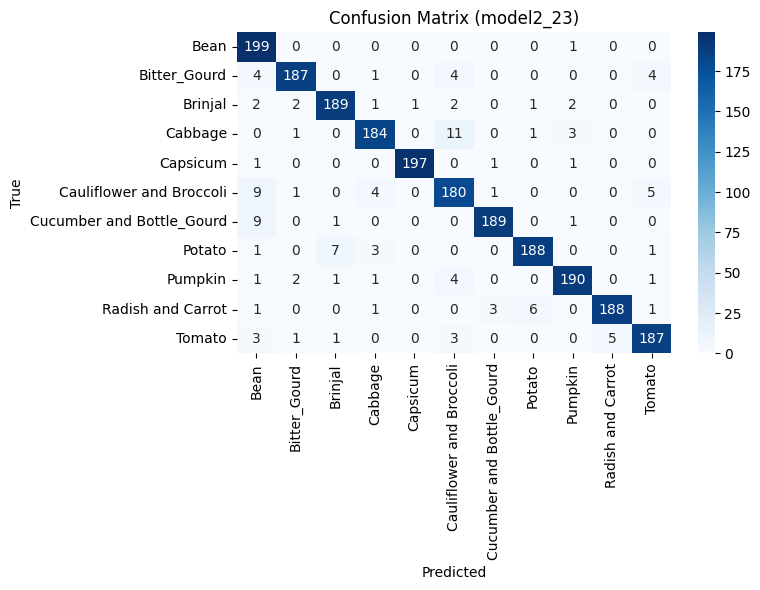

In [23]:
evaluate_model(model2_23, X_test_23, y_test_23, class_names)

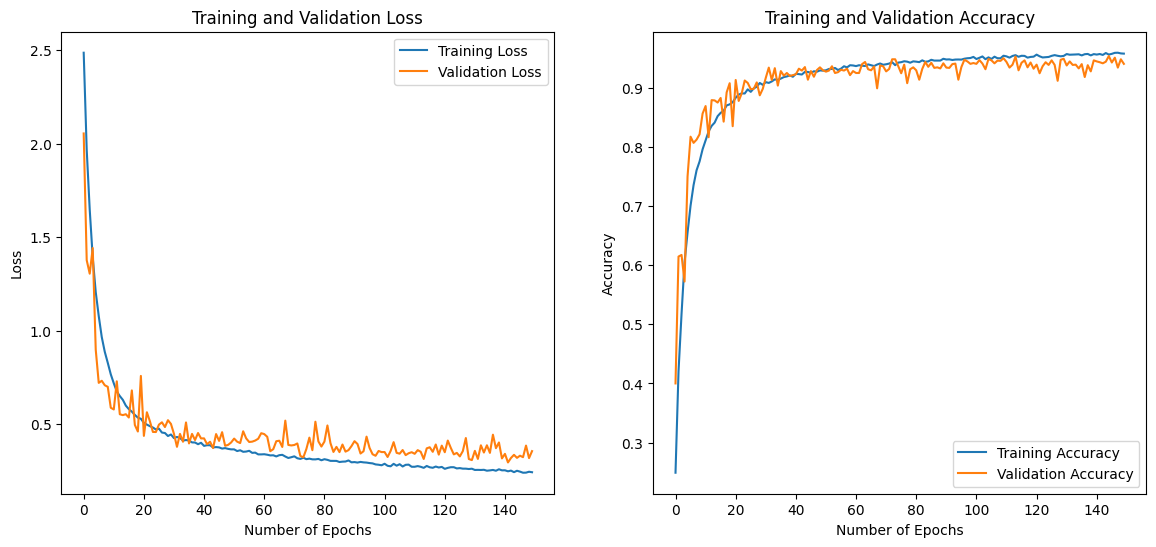

In [24]:
plot_learning_curve(model2_23_history)

# 101x101 Model

In [18]:
# Image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Find how many images per class
unique, counts = np.unique(y_train_101, return_counts=True)
class_counts = dict(zip(unique, counts))

target_count = 2000  # The target no. of images per class after augmentation, 2000

aug_X_train_101 = []
aug_y_train_101 = []

# Loop through each class
for class_idx in unique:
    class_mask = y_train_101 == class_idx  # Mask for current class
    X_class = X_train_101[class_mask]      # Images of current class
    y_class = y_train_101[class_mask]      # Labels of current class
    n_to_add = target_count - len(X_class)  # Number of images to add for balancing
    if n_to_add > 0:
        # Use ImageDataGenerator to augment images for the current class
        aug_iter = datagen.flow(X_class, y_class, batch_size=32, shuffle=True)
        X_aug, y_aug = [], []
        while len(X_aug) < n_to_add:
            X_batch, y_batch = next(aug_iter)
            X_aug.append(X_batch)
            y_aug.append(y_batch)
        # Concatenate and trim to required number of images
        X_aug = np.concatenate(X_aug, axis=0)[:n_to_add]
        y_aug = np.concatenate(y_aug, axis=0)[:n_to_add]
        # Combine original and augmented images/labels
        aug_X_train_101.append(np.concatenate([X_class, X_aug], axis=0))
        aug_y_train_101.append(np.concatenate([y_class, y_aug], axis=0))
    else:
        # If already enough images, just add the originals
        aug_X_train_101.append(X_class)
        aug_y_train_101.append(y_class)

# Concatenate all classes to form the final balanced training set
aug_X_train_101 = np.concatenate(aug_X_train_101, axis=0)
aug_y_train_101 = np.concatenate(aug_y_train_101, axis=0)

print("Original shape: ", X_train_101.shape, y_train_101.shape)
print("Balanced shape: ", aug_X_train_101.shape, aug_y_train_101.shape)

# One-hot encode the augmented labels
aug_y_train_101_cat = to_categorical(aug_y_train_101, num_classes)

Original shape:  (7695, 101, 101, 1) (7695,)
Balanced shape:  (22000, 101, 101, 1) (22000,)


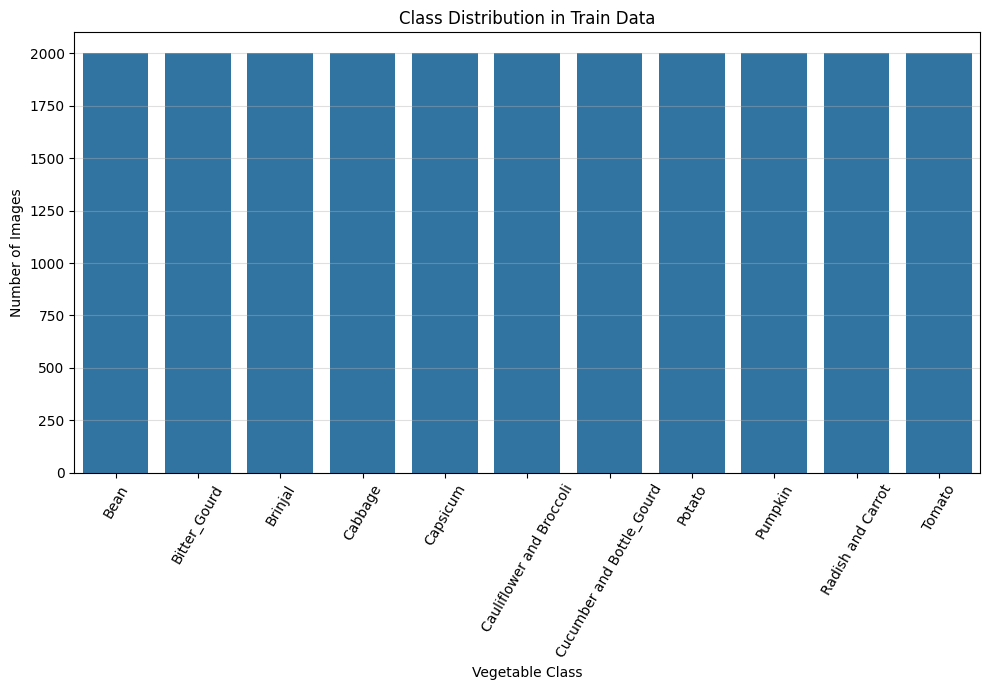

In [19]:
label_names = [class_names[idx] for idx in aug_y_train_101]

# Create a DataFrame
df = pd.DataFrame({'Class': label_names})

# Count and plot
plt.figure(figsize=(10, 7))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel("Vegetable Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train Data")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

## Model training

In [14]:
# One-hot encode the labels
y_train_101_cat = to_categorical(y_train_101, num_classes)
y_val_101_cat = to_categorical(y_val_101, num_classes)
y_test_101_cat = to_categorical(y_test_101, num_classes)

In [127]:
baseline_101 = Sequential(name="baseline_101", layers = [
    Rescaling(1.0/255, input_shape=(101, 101, 1)), # Normalize data
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(101, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

baseline_101.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_101.summary()

Model: "baseline_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 101, 101, 1)       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 99, 99, 64)        640       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 21, 21, 256)      

In [128]:
baseline_101_history = baseline_101.fit(
    X_train_101, y_train_101_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_101, y_val_101_cat),
)

Epoch 1/100
241/241 [==============================] - 7s 26ms/step - loss: 2.0721 - accuracy: 0.2678 - val_loss: 1.7001 - val_accuracy: 0.4105
Epoch 2/100
241/241 [==============================] - 6s 23ms/step - loss: 1.6292 - accuracy: 0.4486 - val_loss: 1.3284 - val_accuracy: 0.5800
Epoch 3/100
241/241 [==============================] - 5s 23ms/step - loss: 1.3448 - accuracy: 0.5439 - val_loss: 1.0475 - val_accuracy: 0.6873
Epoch 4/100
241/241 [==============================] - 5s 23ms/step - loss: 1.0989 - accuracy: 0.6309 - val_loss: 0.9012 - val_accuracy: 0.7168
Epoch 5/100
241/241 [==============================] - 5s 23ms/step - loss: 0.9956 - accuracy: 0.6565 - val_loss: 0.8033 - val_accuracy: 0.7605
Epoch 6/100
241/241 [==============================] - 5s 23ms/step - loss: 0.8273 - accuracy: 0.7085 - val_loss: 0.6827 - val_accuracy: 0.7845
Epoch 7/100
241/241 [==============================] - 6s 23ms/step - loss: 0.7138 - accuracy: 0.7501 - val_loss: 0.5797 - val_accuracy:

69/69 [==============================] - 1s 11ms/step
Overall prediction accuracy: 0.8945
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.92      0.95      0.94       200
             Bitter_Gourd       0.97      0.91      0.94       200
                  Brinjal       0.91      0.90      0.90       200
                  Cabbage       0.90      0.78      0.84       200
                 Capsicum       0.97      0.85      0.91       200
 Cauliflower and Broccoli       0.88      0.90      0.89       200
Cucumber and Bottle_Gourd       0.80      0.95      0.87       200
                   Potato       0.92      0.82      0.87       200
                  Pumpkin       0.94      0.95      0.95       200
        Radish and Carrot       0.85      0.90      0.87       200
                   Tomato       0.83      0.92      0.87       200

                 accuracy                           0.89      2200
             

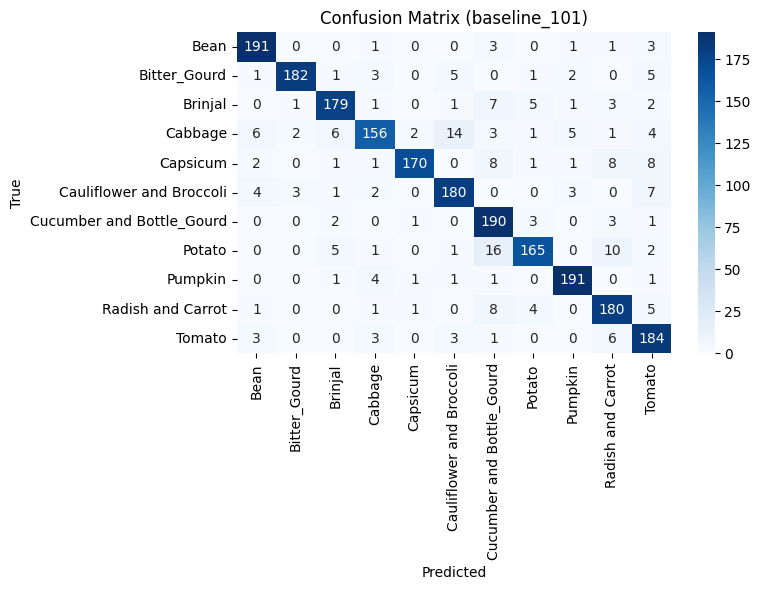

In [130]:
evaluate_model(baseline_101, X_test_101, y_test_101, class_names)

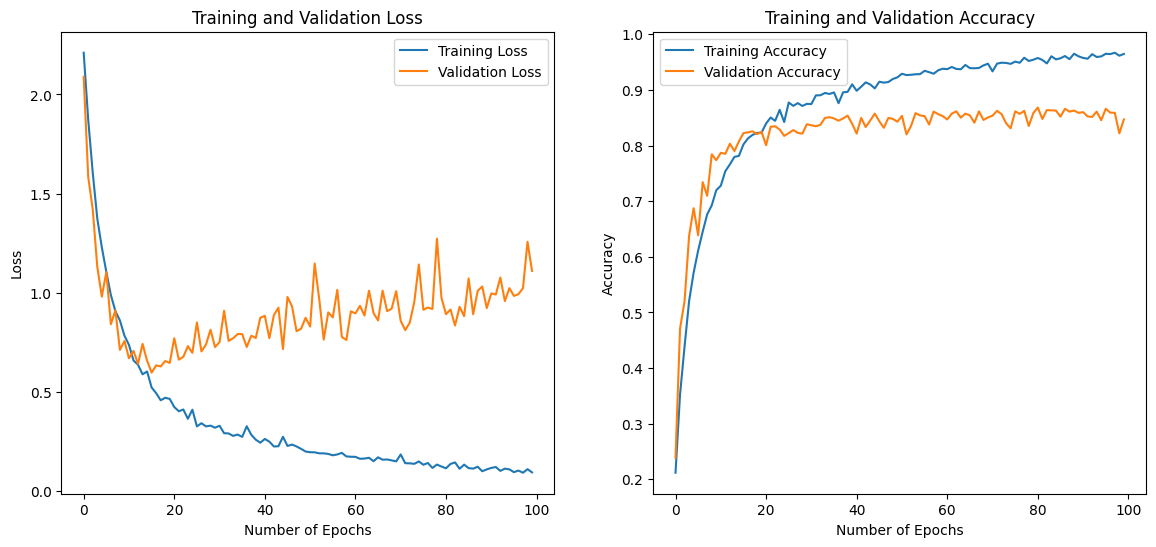

In [ ]:
plot_learning_curve(baseline_101_history)

## Model Improvement

### Augmented Data

In [ ]:
aug_101 = Sequential(name="aug_101", layers = [
    Rescaling(1.0/255, input_shape=(101, 101, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(101, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

aug_101.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

aug_101.summary()

Model: "aug_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_26 (Rescaling)    (None, 101, 101, 1)       0         
                                                                 
 conv2d_85 (Conv2D)          (None, 99, 99, 64)        640       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 21, 21, 256)       2951

In [ ]:
aug_101_history = aug_101.fit(
    aug_X_train_101, aug_y_train_101_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_101, y_val_101_cat),
)

Epoch 1/100
1100/1100 [==============================] - 23s 21ms/step - loss: 1.8732 - accuracy: 0.3394 - val_loss: 1.2859 - val_accuracy: 0.5641
Epoch 2/100
1100/1100 [==============================] - 23s 21ms/step - loss: 1.2693 - accuracy: 0.5594 - val_loss: 0.6852 - val_accuracy: 0.7809
Epoch 3/100
1100/1100 [==============================] - 23s 21ms/step - loss: 0.9679 - accuracy: 0.6630 - val_loss: 0.5029 - val_accuracy: 0.8459
Epoch 4/100
1100/1100 [==============================] - 23s 21ms/step - loss: 0.7800 - accuracy: 0.7264 - val_loss: 0.4544 - val_accuracy: 0.8559
Epoch 5/100
1100/1100 [==============================] - 23s 21ms/step - loss: 0.6491 - accuracy: 0.7741 - val_loss: 0.3790 - val_accuracy: 0.8814
Epoch 6/100
1100/1100 [==============================] - 23s 21ms/step - loss: 0.5436 - accuracy: 0.8094 - val_loss: 0.3543 - val_accuracy: 0.8986
Epoch 7/100
1100/1100 [==============================] - 23s 21ms/step - loss: 0.4701 - accuracy: 0.8354 - val_loss: 0

69/69 [==============================] - 1s 8ms/step
Overall prediction accuracy: 0.9423
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.81      0.99      0.89       200
             Bitter_Gourd       0.98      0.94      0.96       200
                  Brinjal       0.95      0.96      0.96       200
                  Cabbage       0.98      0.86      0.91       200
                 Capsicum       0.98      0.95      0.97       200
 Cauliflower and Broccoli       0.87      0.92      0.90       200
Cucumber and Bottle_Gourd       0.95      0.97      0.96       200
                   Potato       0.97      0.94      0.96       200
                  Pumpkin       0.99      0.95      0.97       200
        Radish and Carrot       0.97      0.93      0.95       200
                   Tomato       0.96      0.94      0.95       200

                 accuracy                           0.94      2200
              

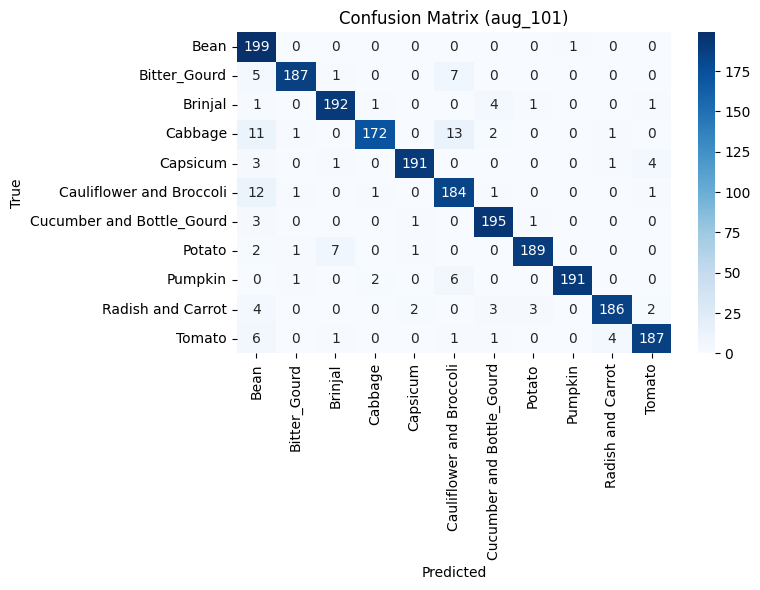

In [148]:
evaluate_model(aug_101, X_test_101, y_test_101, class_names)

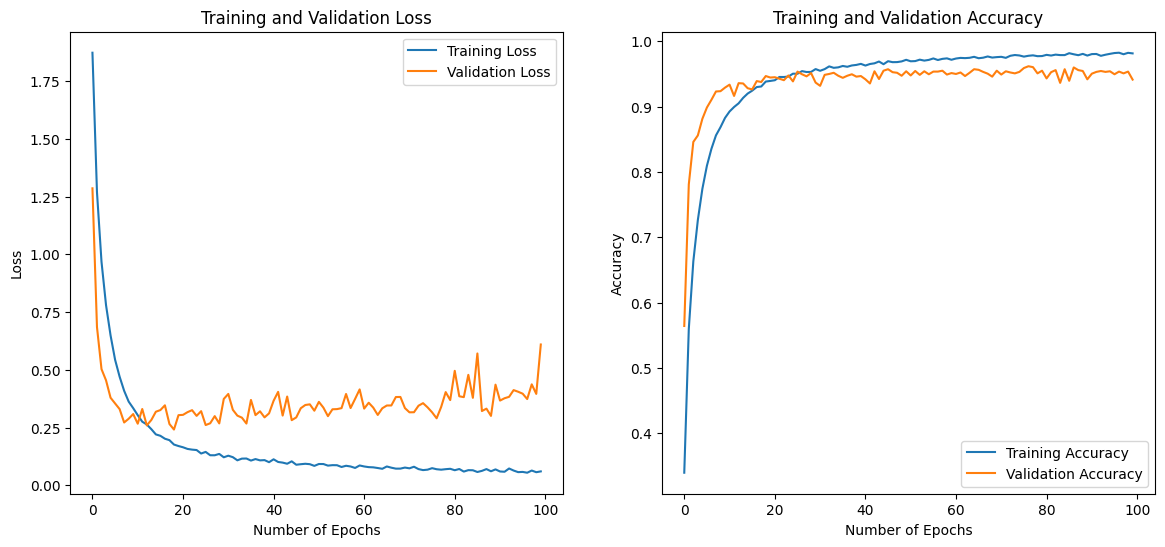

In [149]:
plot_learning_curve(aug_101_history)

Augmented data improves our results and fixes some of the classification problems between similar looking classes

In [34]:
model1_101 = Sequential(name="model1_101", layers = [
    Rescaling(1.0/255, input_shape=(101, 101, 1)), # Normalize data
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    # Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model1_101.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1_101.summary()

Model: "model1_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 101, 101, 1)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 101, 101, 64)      640       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 25, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 25, 25, 256)       2

In [35]:
model1_101_history = model1_101.fit(
    aug_X_train_101, aug_y_train_101_cat, 
    batch_size=32,
    epochs=140,
    validation_data=(X_val_101, y_val_101_cat),
)

Epoch 1/140
688/688 [==============================] - 20s 28ms/step - loss: 1.9544 - accuracy: 0.3657 - val_loss: 1.3635 - val_accuracy: 0.6168
Epoch 2/140
688/688 [==============================] - 19s 28ms/step - loss: 1.4808 - accuracy: 0.5774 - val_loss: 1.0590 - val_accuracy: 0.7427
Epoch 3/140
688/688 [==============================] - 19s 28ms/step - loss: 1.2503 - accuracy: 0.6806 - val_loss: 0.8528 - val_accuracy: 0.8468
Epoch 4/140
688/688 [==============================] - 19s 28ms/step - loss: 1.1058 - accuracy: 0.7455 - val_loss: 0.9512 - val_accuracy: 0.8155
Epoch 5/140
688/688 [==============================] - 19s 28ms/step - loss: 1.0312 - accuracy: 0.7771 - val_loss: 0.7584 - val_accuracy: 0.8859
Epoch 6/140
688/688 [==============================] - 19s 28ms/step - loss: 0.9687 - accuracy: 0.8067 - val_loss: 0.8667 - val_accuracy: 0.8468
Epoch 7/140
688/688 [==============================] - 20s 28ms/step - loss: 0.9045 - accuracy: 0.8280 - val_loss: 0.7443 - val_ac

69/69 [==============================] - 1s 8ms/step
Overall prediction accuracy: 0.9809
Classification Report:

                           precision    recall  f1-score   support

                     Bean       0.98      0.98      0.98       200
             Bitter_Gourd       0.98      0.98      0.98       200
                  Brinjal       0.96      0.98      0.97       200
                  Cabbage       0.98      0.97      0.98       200
                 Capsicum       1.00      0.97      0.99       200
 Cauliflower and Broccoli       0.97      0.97      0.97       200
Cucumber and Bottle_Gourd       0.98      0.98      0.98       200
                   Potato       0.98      0.99      0.99       200
                  Pumpkin       0.99      0.98      0.99       200
        Radish and Carrot       0.97      0.97      0.97       200
                   Tomato       0.99      0.99      0.99       200

                 accuracy                           0.98      2200
              

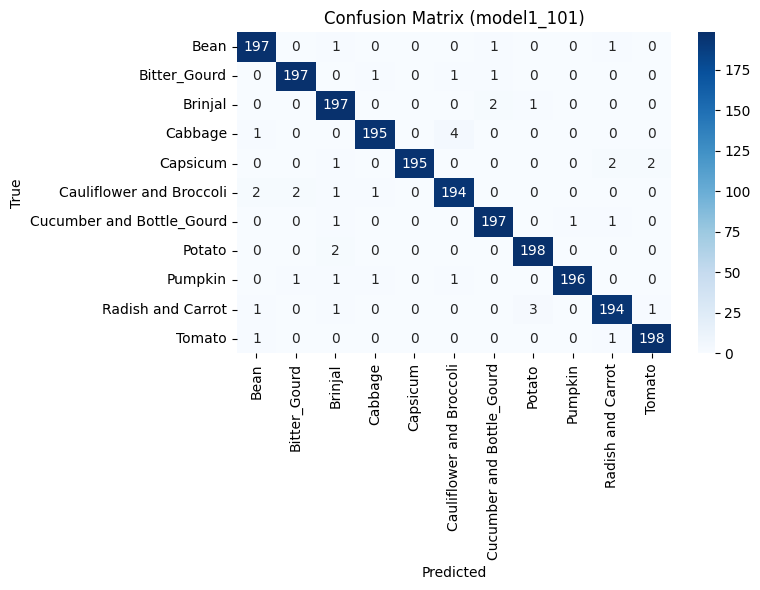

In [36]:
evaluate_model(model1_101, X_test_101, y_test_101, class_names)

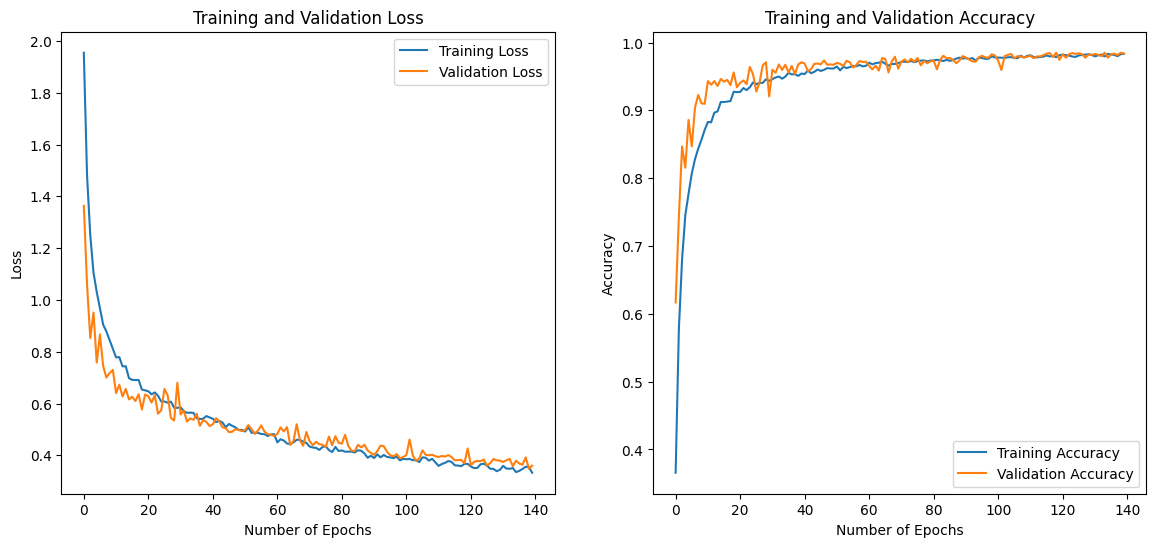

In [37]:
plot_learning_curve(model1_101_history)